In [1]:
import pickle
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import seaborn as sns
import momepy
from shapely.geometry import Point

/home/twenty/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# London

## Roads

The TQ file is still too large so I've manually clipped it to the london boroughs shapefile myself with QGIS

The problem is that those shapefiles exclude the Thames, and any water bodies, cutting off any roads that cross them. This is a limitation in centrality analysis...

also simplified manually with qgis: Douglas-Peucker, 100 meters

In [2]:
# This takes a min
london = gpd.read_file('data/london/roads/simplified/simplified_roads_2.shp')

In [3]:
london.head()

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,primary,trunkRoad,loop,startNode,endNode,structure,nameTOID,numberTOID,function,geometry
0,false,3A60366D-62E3-46A1-8AC8-BB228154EB8A,Unclassified,None,Claremont Avenue,None,None,None,Single Carriageway,107,false,false,false,797BF3A3-3ACE-418E-B337-C9D72BD25D9B,C11A0FAE-1DBC-499E-9523-EC9F1363B404,None,osgb4000000030482852,None,Minor Road,"LINESTRING Z (522527.000 167733.000 0.000, 522..."
1,false,F6463F6D-7F60-4D69-874E-2E565CAB5E43,Unclassified,None,Claremont Avenue,None,None,None,Single Carriageway,435,false,false,false,C11A0FAE-1DBC-499E-9523-EC9F1363B404,D907E403-8799-46E9-B54D-B456D4CE688D,None,osgb4000000030482852,None,Minor Road,"LINESTRING Z (522552.000 167837.000 0.000, 522..."
2,false,338E2466-D3D8-43AF-B696-D2BCC6E42B5D,Unclassified,None,Cavendish Avenue,None,None,None,Single Carriageway,24,false,false,false,C77A4A6B-806C-42D3-A84B-F892A4331AB1,2A0143B5-9621-4DE1-B180-9DC03879668B,None,osgb4000000030486848,None,Local Road,"LINESTRING Z (522562.000 168244.000 0.000, 522..."
3,false,6AADFBDC-0A82-4D6B-BAB9-7A836C1A5BA9,B Road,B282,Burlington Road,None,None,None,Single Carriageway,109,false,false,false,C918C86F-3961-4C57-A4C5-12F76542A7F2,C77A4A6B-806C-42D3-A84B-F892A4331AB1,None,osgb4000000030482854,osgb4000000030576412,B Road,"LINESTRING Z (522652.510 168303.860 0.000, 522..."
4,false,7BA5B37C-3E87-4BD5-B773-38E5DE69B49A,Unknown,None,None,None,None,None,Single Carriageway,104,false,false,false,2A0143B5-9621-4DE1-B180-9DC03879668B,D907E403-8799-46E9-B54D-B456D4CE688D,None,None,None,Secondary Access Road,"LINESTRING Z (522563.530 168219.950 0.000, 522..."


In [4]:
london.function.unique()

array(['Minor Road', 'Local Road', 'B Road', 'Secondary Access Road',
       'Restricted Local Access Road', 'A Road', 'Local Access Road',
       'Motorway'], dtype=object)

In [5]:
lon_major = london.query('function in ["A Road", "Motorway"]') #"B Road"S
lon_major

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,primary,trunkRoad,loop,startNode,endNode,structure,nameTOID,numberTOID,function,geometry
93,false,BA13A0E8-EF16-4287-AD6F-19A67A18E1E8,A Road,A2043,Central Road,None,None,None,Single Carriageway,86,false,false,false,FC95060E-0BD5-47C0-A84F-398854F3B43F,4AC3B5B1-F141-4567-BAA6-7FC08277A729,None,osgb4000000030486740,osgb4000000030576055,A Road,"LINESTRING Z (522524.570 165820.080 0.000, 522..."
101,false,29A65B43-34E5-4D7C-9406-9645FCEDFB1C,A Road,A2043,Central Road,None,None,None,Single Carriageway,80,false,false,false,6C0D3E50-4F47-445F-BEE0-44324652874C,FC95060E-0BD5-47C0-A84F-398854F3B43F,None,osgb4000000030486740,osgb4000000030576055,A Road,"LINESTRING Z (522460.000 165868.000 0.000, 522..."
103,false,C622B742-A8CA-4A87-8937-FC7248CB4851,A Road,A2043,Central Road,None,None,None,Single Carriageway,84,false,false,false,06ACA7DA-B8AF-4DE9-85A4-6EBD63C6CF61,6C0D3E50-4F47-445F-BEE0-44324652874C,None,osgb4000000030486740,osgb4000000030576055,A Road,"LINESTRING Z (522392.000 165917.000 0.000, 522..."
116,false,7AE76AF6-6DD0-4E46-9528-E192D94F0E5A,A Road,A2043,Central Road,None,None,None,Single Carriageway,22,false,false,false,3023EEB4-EBF1-4C69-8C46-224196D3AE72,6E5D2FB9-8B99-448D-A44E-57FED28149B0,None,osgb4000000030486740,osgb4000000030576055,A Road,"LINESTRING Z (522650.300 165726.210 0.000, 522..."
117,false,9843304B-69A8-4CD1-8075-E077CE46804D,A Road,A2043,Central Road,None,None,None,Single Carriageway,42,false,false,false,6F9BB5F4-7AC2-40B2-9102-01A2C1E420A6,3023EEB4-EBF1-4C69-8C46-224196D3AE72,None,osgb4000000030486740,osgb4000000030576055,A Road,"LINESTRING Z (522616.830 165752.390 0.000, 522..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210019,false,DF866DB2-0854-4F8E-831B-E00C437B9946,A Road,A3211,Puddle Dock,None,None,None,Single Carriageway,73,false,false,false,AFA5FAB3-0BCE-40B7-B77B-335A3D15EBAA,9D3D8A72-E90E-4B8F-B1D2-4A546342C56E,None,osgb4000000030554307,osgb4000000030576111,A Road,"LINESTRING Z (531789.230 180953.360 0.000, 531..."
210021,false,FE8A3EA3-3405-4B2D-8F3A-25AD03503F69,A Road,A201,New Bridge Street,None,None,None,Single Carriageway,27,false,false,false,7AF923A0-2FF9-4625-904F-C7B171480CAA,9CE0DE9F-250A-4842-8489-C6E851F1546E,None,osgb4000000030527798,osgb4000000030576301,A Road,"LINESTRING Z (531654.440 180937.920 0.000, 531..."
210022,false,ACD3E0E7-B99D-4630-AA1D-CC21CE7DEBA1,A Road,A3211,Queen Victoria Street,None,None,None,Collapsed Dual Carriageway,63,false,false,false,B31F0907-4AD7-477F-BCC3-35930150CAD6,9CE0DE9F-250A-4842-8489-C6E851F1546E,None,osgb4000000030483246,osgb4000000030576111,A Road,"LINESTRING Z (531712.130 180941.360 0.000, 531..."
210023,false,CE9C38F7-33CB-4BA4-8226-DEAFCA1DDCD1,A Road,A3211,Victoria Embankment,None,None,None,Single Carriageway,215,false,false,false,91ABC116-D119-4CB7-9448-8E3F8E705425,8ABDC348-17EE-4E5C-AC1B-63996080541D,None,osgb4000000030488653,osgb4000000030576111,A Road,"LINESTRING Z (531201.020 180818.120 0.000, 531..."


<AxesSubplot:>

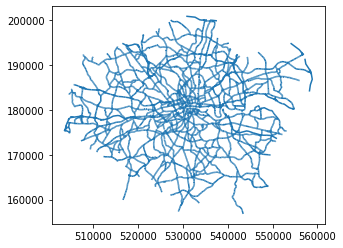

In [6]:
lon_major.plot()

In [7]:
lon_major.geometry.apply(lambda x: x.geom_type).unique()

array(['LineString', 'MultiLineString'], dtype=object)

Some of the geometry are MultiLineStrings, so they need to be splitted...

In [8]:
# literally no mention of index_parts in pandas_dev github...
exploded = lon_major[lon_major.geometry.geom_type == 'MultiLineString'].explode(index_parts=False)
exploded.head()

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,primary,trunkRoad,loop,startNode,endNode,structure,nameTOID,numberTOID,function,geometry
37794,false,656AAAB0-FF08-4A9E-938F-5E7CBF89DA7E,A Road,A316,Great Chertsey Road,None,None,None,Single Carriageway,205,true,false,false,3AAF18DD-3F83-4F7C-92F3-561E14C0CBD3,2BC9CE42-37AD-41A2-B184-8AD1669391DD,None,osgb4000000030487133,osgb4000000030575939,A Road,"LINESTRING Z (520339.000 176406.000 0.000, 520..."
37794,false,656AAAB0-FF08-4A9E-938F-5E7CBF89DA7E,A Road,A316,Great Chertsey Road,None,None,None,Single Carriageway,205,true,false,false,3AAF18DD-3F83-4F7C-92F3-561E14C0CBD3,2BC9CE42-37AD-41A2-B184-8AD1669391DD,None,osgb4000000030487133,osgb4000000030575939,A Road,"LINESTRING Z (520213.697 176273.597 0.000, 520..."
38893,false,AB147D1F-1217-4A88-A879-07E679CC92E1,A Road,A205,Kew Road,None,None,None,Single Carriageway,378,true,false,false,B55CD1E5-B7A2-4792-B974-FC3A9FA92D53,7B5DF7E5-F796-4564-AC53-1F500FFBA64F,None,osgb4000000030482912,osgb4000000030575960,A Road,"LINESTRING Z (518994.860 178017.860 0.000, 518..."
38893,false,AB147D1F-1217-4A88-A879-07E679CC92E1,A Road,A205,Kew Road,None,None,None,Single Carriageway,378,true,false,false,B55CD1E5-B7A2-4792-B974-FC3A9FA92D53,7B5DF7E5-F796-4564-AC53-1F500FFBA64F,None,osgb4000000030482912,osgb4000000030575960,A Road,"LINESTRING Z (519004.740 177786.273 0.000, 519..."
40555,false,450AC005-9BE6-47E9-A2F0-F9CE011137C6,A Road,A305,Richmond Road,None,None,None,Single Carriageway,196,false,false,false,798BED04-91E9-45D1-A566-C4473C7510E7,6F785963-5950-4199-B12B-373EFEA340AA,None,osgb4000000030547470,osgb4000000030576064,A Road,"LINESTRING Z (517623.000 174425.000 0.000, 517..."


In [9]:
lon_major_fixed = pd.concat([lon_major[lon_major.geometry.geom_type != 'MultiLineString'], exploded])
lon_major_fixed

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,primary,trunkRoad,loop,startNode,endNode,structure,nameTOID,numberTOID,function,geometry
93,false,BA13A0E8-EF16-4287-AD6F-19A67A18E1E8,A Road,A2043,Central Road,None,None,None,Single Carriageway,86,false,false,false,FC95060E-0BD5-47C0-A84F-398854F3B43F,4AC3B5B1-F141-4567-BAA6-7FC08277A729,None,osgb4000000030486740,osgb4000000030576055,A Road,"LINESTRING Z (522524.570 165820.080 0.000, 522..."
101,false,29A65B43-34E5-4D7C-9406-9645FCEDFB1C,A Road,A2043,Central Road,None,None,None,Single Carriageway,80,false,false,false,6C0D3E50-4F47-445F-BEE0-44324652874C,FC95060E-0BD5-47C0-A84F-398854F3B43F,None,osgb4000000030486740,osgb4000000030576055,A Road,"LINESTRING Z (522460.000 165868.000 0.000, 522..."
103,false,C622B742-A8CA-4A87-8937-FC7248CB4851,A Road,A2043,Central Road,None,None,None,Single Carriageway,84,false,false,false,06ACA7DA-B8AF-4DE9-85A4-6EBD63C6CF61,6C0D3E50-4F47-445F-BEE0-44324652874C,None,osgb4000000030486740,osgb4000000030576055,A Road,"LINESTRING Z (522392.000 165917.000 0.000, 522..."
116,false,7AE76AF6-6DD0-4E46-9528-E192D94F0E5A,A Road,A2043,Central Road,None,None,None,Single Carriageway,22,false,false,false,3023EEB4-EBF1-4C69-8C46-224196D3AE72,6E5D2FB9-8B99-448D-A44E-57FED28149B0,None,osgb4000000030486740,osgb4000000030576055,A Road,"LINESTRING Z (522650.300 165726.210 0.000, 522..."
117,false,9843304B-69A8-4CD1-8075-E077CE46804D,A Road,A2043,Central Road,None,None,None,Single Carriageway,42,false,false,false,6F9BB5F4-7AC2-40B2-9102-01A2C1E420A6,3023EEB4-EBF1-4C69-8C46-224196D3AE72,None,osgb4000000030486740,osgb4000000030576055,A Road,"LINESTRING Z (522616.830 165752.390 0.000, 522..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196018,false,E8455592-F358-4433-8447-6CB31F447B3B,A Road,A1206,Westferry Road,None,None,None,Roundabout,143,false,false,false,280FFEF6-3A1A-47A5-8B67-23A616C823F2,661F323E-F3A8-41AC-B684-C3CD09870FE3,Road In Tunnel,osgb4000000030502828,osgb4000000030576113,A Road,"LINESTRING Z (536981.886 180347.652 0.000, 537..."
206089,false,5D1E68D2-735E-4E95-8C15-174C38F1A415,A Road,A13,Alfred's Way (East Ham And Barking By-Pass),None,None,None,Collapsed Dual Carriageway,472,true,false,false,759D1736-5FB5-411A-9EC2-7BB3F28B8BDC,62671CCD-D853-4264-B7A5-CFE12F1DC1DB,None,osgb4000000030481379,osgb4000000030880906,A Road,"LINESTRING Z (544637.280 183116.300 0.000, 544..."
206089,false,5D1E68D2-735E-4E95-8C15-174C38F1A415,A Road,A13,Alfred's Way (East Ham And Barking By-Pass),None,None,None,Collapsed Dual Carriageway,472,true,false,false,759D1736-5FB5-411A-9EC2-7BB3F28B8BDC,62671CCD-D853-4264-B7A5-CFE12F1DC1DB,None,osgb4000000030481379,osgb4000000030880906,A Road,"LINESTRING Z (544392.227 183008.459 0.000, 544..."
208640,false,09E52250-3EBB-4D4D-A546-207613305346,A Road,A124,London Road,None,None,None,Single Carriageway,80,false,false,false,D04A4518-8D11-4DC3-8195-9EDA967E26C8,A2C12FCF-2A05-486C-8814-3D3A7FC00B2E,None,osgb4000000030505683,osgb4000000030576142,A Road,"LINESTRING Z (543710.170 184046.490 0.000, 543..."


In [10]:
g_l = momepy.gdf_to_nx(lon_major_fixed, approach="primal")

# Warning: takes forever (like 1 hour)

In [11]:
#primal = momepy.closeness_centrality(g_l, name='closeness_global', weight='mm_len')
#with open('london_edge_centrality.pkl', 'wb') as f:
#    pickle.dump(primal, f)

In [12]:
# if it is dumped, load it instead of calculating
with open('london_edge_centrality.pkl', 'rb') as f:
    primal = pickle.load(f)

In [13]:
momepy.mean_nodes(primal, 'closeness_global')
primal_gdf = momepy.nx_to_gdf(primal, points=False)

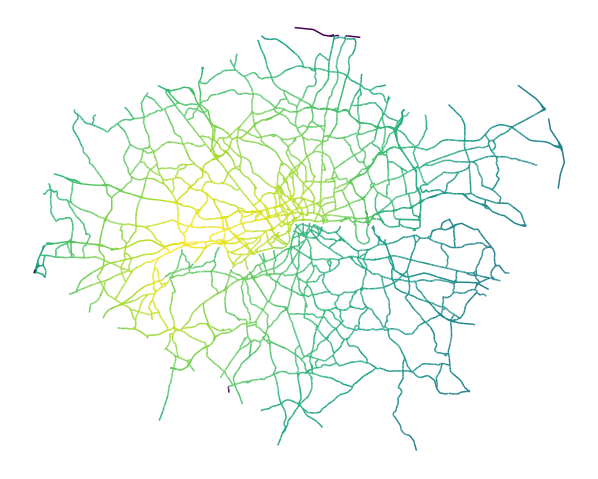

In [14]:
_, ax = plt.subplots(figsize=(10, 7))
primal_gdf.plot('closeness_global', ax=ax)
plt.tight_layout()
plt.axis('off')
plt.savefig('cc_l_edge.png')

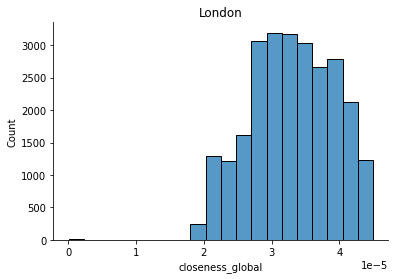

In [17]:
sns.histplot(x=primal_gdf.closeness_global, bins=20)
sns.despine()
plt.title('London')
plt.savefig('figures/l_cc_hist.png')

# No longer need this part as edges are better
# Warning: takes forever (like 30 mins)

In [11]:
# node closeness centrality
#node_centrality = nx.closeness_centrality(g_l)

# Saving it to avoid expensive re-calculation
#with open('london_road_centrality.pkl', 'wb') as f:
#    pickle.dump(node_centrality, f)

# To read it again: run
with open('london_road_centrality.pkl', 'rb') as f:
    node_centrality = pickle.load(f)

In [12]:
l_nc = pd.DataFrame(data=pd.Series(node_centrality), columns=['cc'])

In [13]:
l_nc['colors'] = ox.plot.get_colors(n=len(node_centrality), cmap='inferno', start=0.2)
l_nc.reset_index(inplace=True)
l_nc.rename(columns={'level_0': 'x', 'level_1': 'y'}, inplace=True)
l_nc

,x,y,level_2,cc,colors
0,522524.570000,165820.080000,0.0,0.002838,"(0.258234, 0.038571, 0.406485, 1.0)"
1,522594.000000,165769.000000,0.0,0.002831,"(0.258234, 0.038571, 0.406485, 1.0)"
2,522460.000000,165868.000000,0.0,0.002844,"(0.258234, 0.038571, 0.406485, 1.0)"
3,522392.000000,165917.000000,0.0,0.002850,"(0.258234, 0.038571, 0.406485, 1.0)"
4,522650.300000,165726.210000,0.0,0.002819,"(0.258234, 0.038571, 0.406485, 1.0)"
...,...,...,...,...,...
23891,536981.885591,180347.652019,0.0,0.002677,"(0.988362, 0.998364, 0.644924, 1.0)"
23892,544451.449223,183038.834413,0.0,0.002194,"(0.988362, 0.998364, 0.644924, 1.0)"
23893,544392.226710,183008.458708,0.0,0.002736,"(0.988362, 0.998364, 0.644924, 1.0)"
23894,543733.296971,184059.028014,0.0,0.002773,"(0.988362, 0.998364, 0.644924, 1.0)"


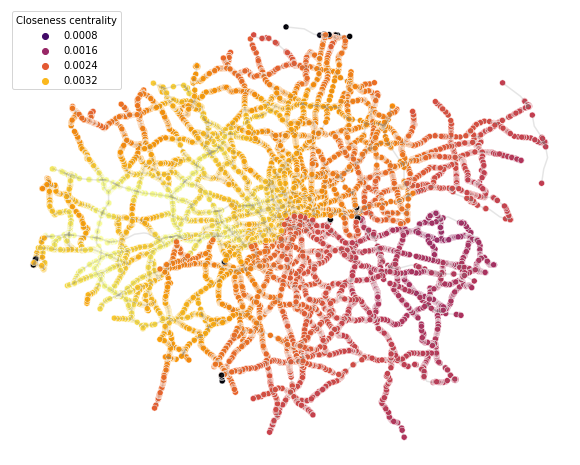

In [14]:
_, ax = plt.subplots(figsize=(10, 7))
lon_major.plot(ax=ax, color='grey', alpha=0.2)
sns.scatterplot(x=l_nc.x, y=l_nc.y, hue=l_nc.cc, palette='inferno', ax=ax)
plt.tight_layout()
plt.axis('off')
ax.legend(title='Closeness centrality')
plt.savefig('cc_l.png')

<AxesSubplot:ylabel='Frequency'>

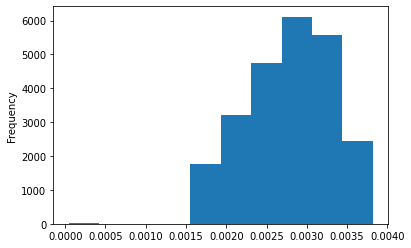

In [15]:
l_nc.cc.plot.hist()